In [49]:
!pip3 install tensorflow==1.12.0

!pip install git+https://www.github.com/keras-team/keras-contrib.git

!pip install tensorflow-gpu==1.12.0

     |████████████████████████████████| 83.1MB 112kB/s 
     |████████████████████████████████| 3.1MB 35.2MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-1djjnn59
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-1djjnn59
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=eb7cbce2570e9a2462d27c9afa5e6f96cd7e658d12d72162548519d490d4de6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-zjl35yfw/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 281.7MB 41kB/s 


In [167]:
# Bidirectional LSTM CRF model


# The code below is just importing the dataset and redoing the same 
#  preprocessing steps that were done in the jupyter notebook for the rest
#  of the models:

from google.colab import files
uploaded = files.upload()

with open("DataNer.txt", "r+") as f:
    d = f.readlines()
    f.seek(0)
    for i in d:
        if i != "-DOCSTART- -X- O O":
            f.write(i)
    f.truncate()

# Read in the dataset with correct column names
import pandas as pd
colnames = ['Word', 'Part_of_speech', 'Chunking', 'NER_tag']
data2 = pd.read_csv("DataNer.txt", names = colnames, delimiter = " ")
data2.head()


import itertools
sentence_num_list = []
curr_sentence_num = 1
with open('DataNer.txt') as f:
    for line in f:
        #print(type(line))
        #print(line)
        if len(line.strip()) == 0:
            curr_sentence_num = curr_sentence_num + 1
        else:
            sentence_num_list.append(curr_sentence_num)
    print("done")

    # Add the list created above as a column of sentence number in our dataframe
data2.insert(4, "Sentence_num", sentence_num_list)
data2.head(5)


# Fill any NA entries and vectorize predictor variables in the dataset
# Here I separated the predictors from the y-values and created two different matrices. For
#  the predictors' matrix (X), I used the to_dict function to create a numerical matrix with
#  the columns containing the counts of each word and the rows referring to each of the 
#  individual words in our dataset. This was done because the first class of models that
#  I built below (SGD, Multinomial Naive Bayes, and Perceptron classifier) take in numerical
#  matrices as opposed to characters/strings that we have in our dataframe above.

data2 = data2.fillna(method='ffill')
data2.head()

from sklearn.feature_extraction import DictVectorizer
X1 = data2.drop('NER_tag', axis=1)
DictVector = DictVectorizer(sparse=True)
X = DictVector.fit_transform(X1.to_dict('records'))
y = data2.NER_tag.values   

Saving DataNer.txt to DataNer (3).txt
done


In [168]:
# Here I am creating a list of words and a list of tags in preparation  
#  to create the padding sequence. 

words=list(set(data2["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print("Number of words:"), 
print(n_words)

tags =list(set(data2["NER_tag"].values))
n_tags = len(tags)
print("Number of tags:"), 
print(n_tags)

# Thus, we see that we have 23825 words in total and verified that there
#  are 8 different NER tags.

Number of words:
23825
Number of tags:
8


In [0]:
# Use the class defined below to get words in their corresponding
#  sentences with their labels.  
#  This will be used below in the steps needed to creating the padding sequence 
#  needed for the bidirectional-lstm crf model, as seen in the cells below.

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t, k) for w, p, t, k in zip(s["Word"].values.tolist(),
                                                           s["Part_of_speech"].values.tolist(),
                                                           s["NER_tag"].values.tolist(),
                                                           s['Chunking'])]
        self.grouped = self.data.groupby("Sentence_num").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data2)
sentences = getter.sentences

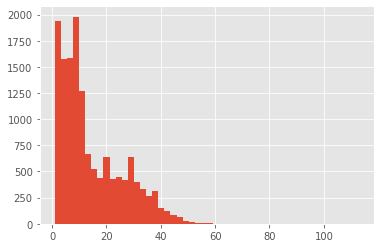

In [171]:
# View a plot of number of words in each sentence (we will use this information
#  to set the maxlen in the padding sequence)
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins=50)
plt.show()

In [0]:
# Get dictionary of words and tags:
#  Here we use the list of words and tags that we created above.  

max_len = 60 # Looking at the number of words in each sentence, we see that
             #  the max length is just below 60
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# We will use these dictionaries to create the padding sequence below.

In [0]:
#pip install --upgrade tensorflow-gpu==1.4
#export PATH="$PATH:/usr/local/cuda-8.0/bin"
#export LD_LIBRARY_PATH="/usr/local/cuda-8.0/lib64"

In [0]:
# Finally, we use the dictionaries created above to 
#  map the words and tags to a sequence of numbers (keeping them contained
#  in their sentences) and then 
#  pad the sequence, creating a matrix of predictors and output values. 
#  This padding is necessary so that the length of each of the nested 
#  arrays representing words in a sentence is the same.

from keras.preprocessing.sequence import pad_sequences

# Prior to the padding sequence being created, we have a list of lists 
#  with inner list containing words in each sentence
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])


In [0]:
# The model will require us to have categorical as opposed to numerical 
#  target values, so we convert y to a binary class matrix.
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [0]:
# Split the data into training and testing sets, with 70% of the data used for 
#  training
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [16]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-ya_655v8
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ya_655v8
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=f1b9c195be655da731930cac8e772fb5e948972d166dca8f20df669487d57b75
  Stored in directory: /tmp/pip-ephem-wheel-cache-k35tm8ig/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
# Import the necessary packages
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras_contrib
from keras_contrib.layers import CRF

In [10]:
#pip install keras==2.2.4

In [177]:
# In order to build the deep learning Bidirectional LSTM-CRF model, 
#  first instantiated a keras tensor with Input(), 
#  specifying the shape/dimension of the array that it will take in.  
#  I then built the embedding or input layer specifying the number of words,
#  or size of the vocabulary, the output dimension 
#  (I used 20 as an arbitrary value since this parameter just 
#  indicates the size of the fully connected layer), and the input length
#  (I specified this to the length of the longest sentence in words.) 
#  Next, I added the hidden layer as a long short-term memory recurrent 
#  neural network, specifying the dimension of the inner cells to be 50 
#  (arbitrary value).  I also specified the return_sequences parameter to 
#  'True' so that I would be able to access all the hidden state ouput for each 
#  time step, as opposed to just the last one in the sequence
#   I added a bidirectional wrapper on top of it.
#  Then I added a dense time distributed layer as a wrapper so that the model 
#  will take into account the order of the sequence in our dataset.  I again
#  used 50 as the dimensionality of the ouptu space since this parameter needed
#  to be specified.
#  Finally, I added a CRF layer and specified the number of output classes/
#  number of tags.
#  When compiling the model, I specified the accuracy metric to be
#  calculted so that I could plot and evaluate it along with the loss.
#  I specified optimizer to be 'rmsprop', a common optimizer
#  used in neural networks, and set the loss function to the specific 
#  crf method.
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20, input_length=max_len)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True))(model)  # variational biLSTM
model = TimeDistributed(Dense(50))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [157]:
# View the model summary
model.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 60, 20)            476520    
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 60, 100)           28400     
_________________________________________________________________
time_distributed_41 (TimeDis (None, 60, 50)            5050      
_________________________________________________________________
crf_45 (CRF)                 (None, 60, 8)             488       
Total params: 510,458
Trainable params: 510,458
Non-trainable params: 0
_________________________________________________________________


In [178]:
# Fit the model to our training set using a batch size of 32 with 5 epochs.  
#  These numbers were chose based on common numbers used for NER models
#  that I found online.  (Each epoch is one forward and backward pass of the
#  data, and the batch size is the number of individual data samples/rows
#  included in the epoch).  Like the other models I found, I wanted to keep
#  the batch size relatively small compared to the size of our dataset
#  so that the neural network will train faster.
my_history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5)

Epoch 1/5
10044/10044 [==============================] - 77s 8ms/step - loss: 0.1595 - crf_viterbi_accuracy: 0.9514
Epoch 2/5
10044/10044 [==============================] - 67s 7ms/step - loss: 0.0491 - crf_viterbi_accuracy: 0.9775
Epoch 3/5
10044/10044 [==============================] - 67s 7ms/step - loss: 0.0191 - crf_viterbi_accuracy: 0.9881
Epoch 4/5
10044/10044 [==============================] - 68s 7ms/step - loss: -4.4676e-04 - crf_viterbi_accuracy: 0.9933
Epoch 5/5
10044/10044 [==============================] - 67s 7ms/step - loss: -0.0126 - crf_viterbi_accuracy: 0.9956


In [159]:
#print(my_history.history.keys())

dict_keys(['loss', 'crf_viterbi_accuracy'])


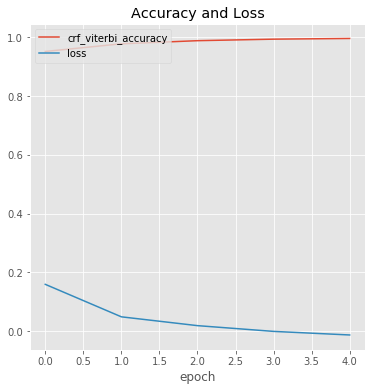

In [179]:
# Plot the loss and accuracy curves
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(6,6))
plt.title('Accuracy and Loss')
plt.xlabel('epoch')
plt.plot(my_history.history['crf_viterbi_accuracy'])
plt.plot(my_history.history['loss'])
plt.legend(['crf_viterbi_accuracy', 'loss'], loc='upper left')
plt.show()

# We can see that as the number of epochs increases, there is a slight increase 
#  in accuracy, and the loss function decreases by a visible amount
#  after the first epoch.  (We want to minimize the loss, which is the amount
#  by which the model's predictions deviate from the actual results).

In [180]:
!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_pred = model.predict(X_te, verbose=1)

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))




4305/4305 [==============================] - 15s 4ms/step
F1-score: 79.5%


In [182]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      ORG       0.78      0.73      0.75      1999
      LOC       0.90      0.85      0.88      2175
     MISC       0.69      0.70      0.70      1025
      PER       0.79      0.81      0.80      2067

micro avg       0.80      0.79      0.79      7266
macro avg       0.81      0.79      0.80      7266



In [0]:
# From the model's f1 score of .795, we can see that the Bidirectional LSTM CRF 
#  performs fairly well, though not as well as the CRF model, MNB, or the 
#  Perceptron model.  However, we can see that it is more consistent in 
#  predicting more tags with a relatively high precision and recall, when
#  compared to the SGD and Perceptron, which only predicted a couple of 
#  non-'O' and with a much lower precision, and no recall (0).  
#  From the precision and recall scores, we can see that
#  this model is able to predict well for the NER tags of the class 'ORG', 
#  'LOC', 'MISC', and 'PER' (corresponding to the different types of entities).
#  However, it's important to note that the CRF also has 
#  high recall and precision for predicting the same entities.

In [0]:
# In conclusion, the best performing model is the CRF, since it has the highest
#  f1 score of .936.  Though the MNB has the next highest f1 score at .92,
#  further justification for the CRF being the better model comes from
#  comparing the precision and recall values for each of the NER tags/
#  categories: Both the MNB and CRF have relatively high precision and recall
#  values for the 'I-LOC', 'I-MISC', 'I-ORG', and 'I-PER' entities, 
#  but we can see that these values for the CRF are all above .8, 
#  wheras they are lower for the MNB.  As reference, the classification reports 
#  for the MNB and CRF are copied below.

In [0]:
 # MNB:
 #precision    recall  f1-score   support

#       B-LOC       0.00      0.00      0.00         5
#      B-MISC       0.00      0.00      0.00        10
#       B-ORG       0.00      0.00      0.00         4
#       I-LOC       0.89      0.62      0.73      2456
#      I-MISC       0.65      0.19      0.30      1490
#       I-ORG       0.77      0.63      0.70      3035
#       I-PER       0.73      0.82      0.77      3406
#           O       0.95      0.99      0.97     51775

# CRF:
#precision    recall  f1-score   support

 #      B-LOC      0.000     0.000     0.000         1
 #      I-LOC      0.884     0.830     0.856      2444
 #     B-MISC      0.000     0.000     0.000         8
 #     I-MISC      0.894     0.735     0.806      1429
 #      B-ORG      0.000     0.000     0.000         0
 #      I-ORG      0.802     0.764     0.783      2809
 #      I-PER      0.842     0.908     0.874      2743

 #  micro avg      0.847     0.818     0.832      9434
 #  macro avg      0.489     0.462     0.474      9434
#weighted avg      0.848     0.818     0.831      9434
